In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as smf

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Evaluation metrics for regression problems

Evaluation metrics are useful for explaining the accuracy of our models, comparing different models, and deciding which variables to include into a model.

Let's create some example numeric predictions, and calculate three common evaluation metrics for regression problems:

In [2]:
# define true and predicted response values
y_true = [100, 50, 30, 20]
y_pred = [90, 50, 50, 30]

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

In [3]:
print metrics.mean_absolute_error(y_true, y_pred)

10.0


**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

In [4]:
print metrics.mean_squared_error(y_true, y_pred)

150.0


**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [5]:
print np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print metrics.mean_squared_error(y_true, y_pred) ** 0.5

12.2474487139
12.2474487139


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [6]:
# same true values as above
y_true = [100, 50, 30, 20]

# new set of predicted values
y_pred = [60, 50, 30, 20]

# MAE is the same as before
print metrics.mean_absolute_error(y_true, y_pred)

# RMSE is larger than before
print np.sqrt(metrics.mean_squared_error(y_true, y_pred))

10.0
20.0


### Computing evaluation metrics for our linear model on the advertising dataset

Let's compute these evaluation metrics for the linear model we have developed for our advertising dataset

In [7]:
# read data into a DataFrame
advert = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
advert.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [8]:
factors = ["TV", "Radio", "Newspaper"]
X = advert[factors]
y = advert["Sales"]

In [9]:
lm = smf.ols(formula="Sales ~ TV + Radio + Newspaper", data=advert).fit()
sales_preds = lm.predict(X)

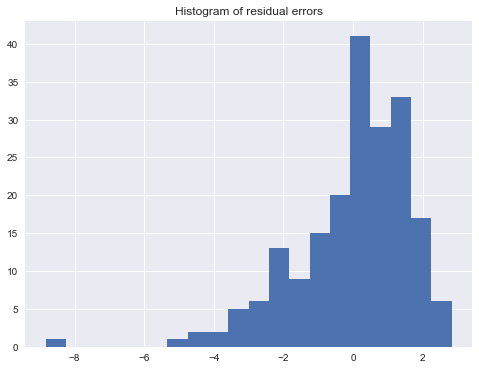

In [10]:
plt.figure(figsize=(8,6))
plt.hist(y - sales_preds, bins=20)
plt.title("Histogram of residual errors")
plt.show()

Plotting the residual errors provides us a useful indication of how our model is performing. Ideally, we would like the errors to be normally distributed around zero with minimal variance.

In [11]:
print "R squared:", lm.rsquared
print "Adjusted R squared:", lm.rsquared_adj
print "MAE:", metrics.mean_absolute_error(y, sales_preds)
print "MSE:", metrics.mean_squared_error(y, sales_preds)
print "RMSE:", np.sqrt(metrics.mean_squared_error(y, sales_preds))

R squared: 0.897210638179
Adjusted R squared: 0.89563733162
MAE: 1.25201122969
MSE: 2.78412631451
RMSE: 1.66857014072


Our model looks pretty good, with a fairly low RMSE. Remember that the model is fitted to minimize squared errors, but we don't know how it will perform on unseen or new data.

### Bias vs Variance

Let's explore the problem of overfitting, looking at an extreme example. We first generate a hypothetical function which represents a ground truth along with some random noise.

In [12]:
func = lambda x: (x-5)**2 
noise = lambda x: np.random.normal(scale=5.0, size=len(x))

In [19]:
n = 10
x_sample = np.linspace(0, 15, n)
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

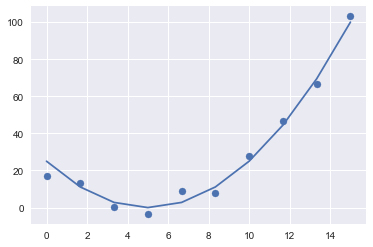

In [20]:
plt.scatter(x_sample, y_sample)
plt.plot(x_sample, func(x_sample))
plt.show()

We then proceed to construct three models of varying complexity by creating additional polynomial features.

**PolynomialFeatures**: Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

We will cover pipelines in more detail in future lessons 

**Pipelines**: Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

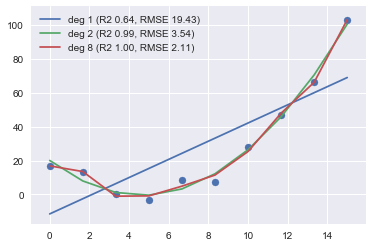

In [22]:
degrees = [1,2,8]
models = []
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(df[['x']], df['y'])
    y_pred = model.predict(df[['x']])
    plt.plot(df[['x']], y_pred, label="deg %d (R2 %.2f, RMSE %.2f)" %
             (degree, model.score(df[['x']], df['y']), np.sqrt(metrics.mean_squared_error(df['y'], y_pred))))
    models.append(model)
    
plt.scatter(x_sample, y_sample)    
plt.legend()
plt.show()

The most complex model with the highest polynomial features has the lowest RMSE but it may just be overfitting the data and connecting all the dots. 

- It's actually a result from algebra that you can fit *any* finite set of data points with a polynomial. 
- In fact, for any set of $n$ data points, there exists a polynomial of degree $n$ that goes right through them.
- This is great if you want to approximate your data arbitrarily closely.
- It's not great if you are afraid of overfitting your data

Let's test the models against some new data.

In [23]:
n = 50
x_test = np.linspace(0, 15, n)
y_test = func(x_test) + noise(x_test) 
df_test = pd.DataFrame({'x': x_test, 'y': y_test})

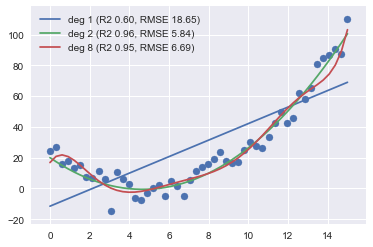

In [24]:
for degree, model in zip(degrees, models):
    y_pred = model.predict(df_test[['x']])
    plt.plot(df_test[['x']], y_pred, label="deg %d (R2 %.2f, RMSE %.2f)" % 
             (degree, model.score(df_test[['x']], df_test['y']), 
              np.sqrt(metrics.mean_squared_error(df_test['y'], y_pred))))
plt.legend()
plt.scatter(x_test, y_test)    
plt.show()

The first model is biased as a linear model isn't able to fully capture the quadratic relationship. The model with a high number of degrees has overfitted the training set and doesn't perform well on previously unseen data.  

### Model Evaluation

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [25]:
train, test = model_selection.train_test_split(advert, test_size=0.4, random_state=50)
train.shape, test.shape

((120, 4), (80, 4))

In [26]:
lm_overfit = smf.ols(formula="Sales ~ I(TV ** 2) + I(TV ** 3) + I(TV ** 4) + I(TV ** 5) \
             + I(Radio ** 2) + I(Radio ** 3) + I(Radio ** 4) + I(Radio ** 5) \
             + I(Newspaper ** 2) + I(Newspaper ** 3) + I(Newspaper ** 4) + I(Newspaper ** 5)", data=train).fit()
#lm_overfit.summary()

In [27]:
lm_simple = smf.ols(formula="Sales ~ TV + Radio + Newspaper", data=train).fit()
#lm_simple.summary()

In [28]:
print "Overfitted Model Training MSE: %f" % metrics.mean_squared_error(lm_overfit.predict(train), train["Sales"])
print "Simple Model Training MSE: %f" % metrics.mean_squared_error(lm_simple.predict(train), train["Sales"])

Overfitted Model Training MSE: 2.139992
Simple Model Training MSE: 3.160282


In [29]:
print "Overfitted Model Test MSE: %f" % metrics.mean_squared_error(lm_overfit.predict(test), test["Sales"])
print "Simple Model Test MSE: %f" % metrics.mean_squared_error(lm_simple.predict(test), test["Sales"])

Overfitted Model Test MSE: 4.719034
Simple Model Test MSE: 2.408094


### Cross Validation 

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

In [34]:
n = 30
x_sample = np.linspace(0, 15, n)
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

In [35]:
kf = model_selection.KFold(n_splits=5, shuffle=True)
for degree in [1, 2, 8]:
    print "Degree", degree
    rmse_values = []
    scores = []
    models = []
    n = 0
    for train_index, test_index in kf.split(df):
        n += 1
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        rmse_values.append(np.sqrt(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"])))
        scores.append(model.score(df[['x']], df['y']))
        print 'Model', n
        print 'RMSE:', rmse_values[n-1]
        print 'R2:', scores[n-1]

    print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
    print 'Mean of RMSE for all folds:', np.mean(rmse_values)
    print 'Mean of R2 for all folds:', np.mean(scores)
    print

Degree 1
Model 1
RMSE: 14.7556286074
R2: 0.633659679083
Model 2
RMSE: 18.2072625868
R2: 0.626307467343
Model 3
RMSE: 20.3810929098
R2: 0.629141722929
Model 4
RMSE: 21.8746370115
R2: 0.615352377353
Model 5
RMSE: 22.0931941953
R2: 0.632627723161
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 19.4623630621
Mean of R2 for all folds: 0.627417793974

Degree 2
Model 1
RMSE: 4.48876463489
R2: 0.977119090477
Model 2
RMSE: 6.87857737993
R2: 0.973362070951
Model 3
RMSE: 6.07504174261
R2: 0.97541881115
Model 4
RMSE: 4.53628597475
R2: 0.976384243516
Model 5
RMSE: 7.33826343845
R2: 0.973639875953
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.86338663413
Mean of R2 for all folds: 0.975184818409

Degree 8
Model 1
RMSE: 8.6872718504
R2: 0.973236299585
Model 2
RMSE: 4.17362753571
R2: 0.978756689298
Model 3
RMSE: 9.75430673838
R2: 0.963103858128
Model 4
RMSE: 6.65763225508
R2: 0.977324288887
Model 5
RMSE: 6.56985029217
R2: 0.976957230093
~~~~ SUMMARY OF CROSS VALI

### Cross Validation on the advertising dataset

In [37]:
rmse_list = []
n = 0
for train_index, test_index in kf.split(advert):
    n += 1
    train = advert.iloc[train_index]
    test = advert.iloc[test_index]
    lm = smf.ols(formula = "Sales ~ TV + Radio + Newspaper", data=train).fit()
    ypreds = lm.predict(test[["TV", "Radio", "Newspaper"]])
    rmse = np.sqrt(metrics.mean_squared_error(ypreds, test["Sales"]))
    rmse_list.append(rmse)
    print "Model %d RMSE: %f" % (n, rmse)
print "Average RMSE:", np.mean(rmse_list)

Model 1 RMSE: 1.374271
Model 2 RMSE: 2.422256
Model 3 RMSE: 1.297710
Model 4 RMSE: 1.885700
Model 5 RMSE: 1.771714
Average RMSE: 1.75033011185


### Using Sklearn

Let's practice cross validation and construct the model this time using Sklearn

In [74]:
rmse_list = []
n = 0
for train_index, test_index in kf.split(advert):
    n += 1
    train = advert.iloc[train_index]
    test = advert.iloc[test_index]
    model = LinearRegression().fit(train[["TV", "Radio", "Newspaper"]], train["Sales"])
    ypreds = model.predict(test[["TV", "Radio", "Newspaper"]])
    rmse = np.sqrt(metrics.mean_squared_error(ypreds, test["Sales"]))
    rmse_list.append(rmse)
    print "Model %d RMSE: %f" % (n, rmse)
print "Average RMSE:", np.mean(rmse_list)

Model 1 RMSE: 1.895918
Model 2 RMSE: 1.616483
Model 3 RMSE: 2.146087
Model 4 RMSE: 1.382516
Model 5 RMSE: 1.562041
Average RMSE: 1.72060894395


### Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

### Cross-validation recommendations

- K can be any number, but **K = 5 or 10** is generally recommended
- For classification problems, **stratified sampling** is recommended for creating the folds i.e. Each response class should be represented with equal proportions in each of the K folds

### Regularization 

If your model is very complex (i.e., lots of features, possibly a polynomial fit, etc.), you need to worry more about overfitting.
- You'll need regularization when your model is complex, which happens when you have little data or many features.
- We'll fit the (unregularized) `LinearRegression`, as well as the (regularized) `Ridge` and `Lasso` model.
  - Lasso regression imposes an L1 prior on the coefficient, causing many coeffiecients to be zero.
  - Ridge regression imposes an L2 prior on the coefficient, causing outliers to be less likely, and coeffiecients to be small across the board.

Let's revisit the hypothetical model we created earlier and see if applying regularization can prevent the overfitting we previously observed with high polynomial features.

In [143]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
n = 30
x_sample = np.linspace(0, 15, n)
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

In [144]:
mse_values = []
for train_index, test_index in kf.split(df):
    degree = 10
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
    y_pred = model.predict(df.iloc[test_index][['x']])
    mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
print 'RMSE: ', np.sqrt(np.mean(mse_values))

RMSE:  13.4554029515


### Ridge Regression 

In [145]:
alphas = np.logspace(-4, 4, 9)
for alpha in alphas:
    mse_values = []
    for train_index, test_index in kf.split(df):
        degree = 10
        model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha)).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
    print 'Alpha: %f RMSE: %f' % (alpha, np.sqrt(np.mean(mse_values)))

Alpha: 0.000100 RMSE: 6.314118
Alpha: 0.001000 RMSE: 6.029243
Alpha: 0.010000 RMSE: 5.641607
Alpha: 0.100000 RMSE: 5.925178
Alpha: 1.000000 RMSE: 6.735292
Alpha: 10.000000 RMSE: 8.956705
Alpha: 100.000000 RMSE: 12.005225
Alpha: 1000.000000 RMSE: 24.085575
Alpha: 10000.000000 RMSE: 28.788325


### Lasso 

In [146]:
alphas = np.logspace(-4, 4, 9)
for alpha in alphas:
    mse_values = []
    for train_index, test_index in kf.split(df):
        degree = 10
        model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Lasso(alpha)).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
    print 'Alpha: %f RMSE: %f' % (alpha, np.sqrt(np.mean(mse_values)))

Alpha: 0.000100 RMSE: 5.575833
Alpha: 0.001000 RMSE: 5.564852
Alpha: 0.010000 RMSE: 5.430705
Alpha: 0.100000 RMSE: 5.701218
Alpha: 1.000000 RMSE: 8.099878
Alpha: 10.000000 RMSE: 13.414331
Alpha: 100.000000 RMSE: 29.450383
Alpha: 1000.000000 RMSE: 29.450383
Alpha: 10000.000000 RMSE: 29.450383


### Bonus: We can use GridSearch to automate all this! 

In [147]:
pipe = make_pipeline(PolynomialFeatures(10), StandardScaler(), Lasso())
alphas = np.logspace(-4, 4, 9)
gs = model_selection.GridSearchCV(
    estimator=pipe,
    param_grid={'lasso__alpha': alphas},
    scoring='neg_mean_squared_error',
    cv=kf)

gs.fit(df[['x']], df['y'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [122]:
gs.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [123]:
gs.best_params_

{'lasso__alpha': 0.01}

In [124]:
gs.best_score_

-25.409702595533386

In [125]:
np.sqrt(-gs.best_score_)

5.0408037648309012